# Model Selection for Neural Networks

## Setup

In [53]:
import os

## adapt this directory to your needs
base_dir = '../'
notebook_dir = os.path.join(base_dir, 'Exercise')
data_dir = os.path.join(base_dir, 'DataSets')

In [54]:
import random

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score

import tensorflow as tf

from pyMLaux import show_img_data, evaluate_classification_result

## Load Simple Digit Recognition Data

In [55]:
dig_train_raw = pd.read_csv(os.path.join(data_dir,'Digits_training.csv'), sep=',')
dig_train = {'data': np.array(dig_train_raw.iloc[:, :-1]),
             'target': np.array(dig_train_raw.iloc[:, -1]),
             'feature_names': dig_train_raw.columns[:-1],
             'target_names': [str(i) for i in range(0, 10)]}

In [56]:
dig_test_raw = pd.read_csv(os.path.join(data_dir, 'Digits_test.csv'), sep=',')
dig_test = {'data': np.array(dig_test_raw.iloc[:, :-1]),
            'target': np.array(dig_test_raw.iloc[:, -1]),
            'feature_names': dig_test_raw.columns[:-1],
            'target_names': [str(i) for i in range(0, 10)]}

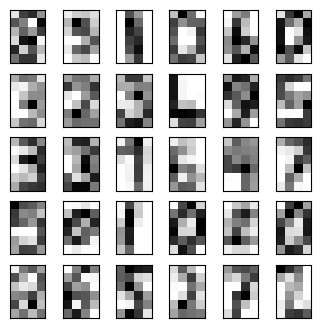

In [57]:
show_img_data(dig_train['data'].reshape((dig_train['data'].shape[0], 6, 4, 1)), figsize=(4, 4),
              interpolation=None)

In [58]:
dig_train['target'][range(0, 30)].reshape(5, 6)

array([[8, 5, 1, 0, 6, 0],
       [3, 2, 3, 4, 9, 5],
       [3, 3, 1, 6, 4, 7],
       [5, 0, 1, 0, 2, 0],
       [2, 6, 5, 2, 7, 2]])

In [59]:
X_train, X_val, y_train, y_val = train_test_split(dig_train['data'], dig_train['target'],
                                                  test_size=0.3, random_state=4232)

## Functions for Hyperparameter/Architecture Selection


In a previous run, I identfied architecture types which where able to achieve high accuracy. This was identified using this function by searching over 3000 models:

```python
def create_hyperparams(n, default_lr=0.001):
    df = pd.DataFrame(index=range(n),
                      columns=['no_hidden_layers', 'hidden_layers', 'activation', 'dropout', 'lr', 'epochs'])

    for i in range(n):
        df.loc[i, 'lr'] = default_lr * 5.**random.uniform(-1., 1.)
        df.loc[i, 'epochs'] = random.sample([64, 128, 256], 1)[0] # Removed 16 and 32 epochs ==> too few epochs. Also added 256

        no_layers = random.randint(2, 8) # Zero and 1 hidden layers make no sense. Also increase to 8 hidden layers instead of 4
        df.loc[i, 'no_hidden_layers'] = no_layers

        # Number of neuron in hidden layers: Remove random sampling, because it makes no sense if neuron counts are random ==> implement a decreasing pattern
        # This value is only the initial value
        # Create decreasing layer sizes
        initial_size = random.sample([784, 392], 1)[0]  # Start large to capture all information ( 28x28 = 784 pixels or 28x14 = 392 pixels)
        layer_sizes = [initial_size]
        
        # Calculate reduction factor
        reduction = (initial_size / 32) ** (1.0 / (no_layers - 1))
        
        # Generate remaining layers with smooth size reduction
        current_size = initial_size
        for _ in range(no_layers - 1):
            current_size = int(current_size / reduction)
            current_size = max(32, min(current_size, layer_sizes[-1]))  # Ensure smooth decrease
            layer_sizes.append(current_size)
            
        df.loc[i, 'hidden_layers'] = layer_sizes

        # df.loc[i, 'hidden_layers'] = [int(random.sample([32, 64, 128, 256, 512], 1)[0]) for i in range(no_layers)] # 
        df.loc[i, 'dropout'] = random.sample([0.2, 0.3, 0.4, 0.5], 1)[0] # Removed 0 dropout, because it is not recommended for deep networks
        df.loc[i, 'activation'] = random.sample(['relu', 'elu'], 1)[0] # Removed sigmoid, because it does not train well for deep networks

    return(df)
```

The most promising architectures were:

```python
architecture_type = random.choice([
            [784, 158, 32],  # Winner architecture
            [784, 32],       # Simple but effective
            [784, 256, 32],  # Variation of winner
            [784, 196, 32],  # Another variation
            [784, 128, 32],  # Third variation
        ])
```

So now I am running the hyperparameter search again, but with the above architectures only. This should speed up the search and also increase the likelihood of finding a good model, because now I only have to vary the hyperparameters and not the architecture itself. The hyperparameter ranges were also narrowd down to the most promising values:
* activation: relu ==> removed elu, because relu was almost always better
* dropout: Narrowed down to 0.15 0.2, and 0.25 ==> removed 0.3 and 0.4, because they were not as good
* epochs: Fixed to 256 ==> good balance between training time and accuracy
* lr: Narrowed to these values 0.0004, 0.0005, 0.0006, 0.0008, 0.001, 0.0015, 0.002

So now only 1000 models with the above architectures and the narrowed down hyperparameters will be trained as a last refinement step. For this lr sheduling was also added to the training process. This resulted in:
* overall accuracy: 95.808%

In [60]:
def create_hyperparams(n, default_lr=0.001):
    df = pd.DataFrame(index=range(n),
                      columns=['no_hidden_layers', 'hidden_layers', 'activation', 'dropout', 'lr', 'epochs'])

    for i in range(n):
        # Focus on proven architectures
        architecture_type = random.choice([
            [784, 158, 32],  # Winner architecture
            [784, 32],       # Simple but effective
            [784, 256, 32],  # Variation of winner
            [784, 196, 32],  # Another variation
            [784, 128, 32],  # Third variation
        ])
        
        df.loc[i, 'no_hidden_layers'] = len(architecture_type)
        df.loc[i, 'hidden_layers'] = architecture_type
        
        # Fine-tuned learning rate range
        df.loc[i, 'lr'] = random.choice([
            0.0004, 0.0005, 0.0006, 0.0008, 0.001, 0.0015, 0.002
        ])
        
        # Proven epoch counts
        df.loc[i, 'epochs'] = 256
        
        # Optimal dropout range
        df.loc[i, 'dropout'] = random.choice([0.15, 0.2, 0.25])
        
        # Stick with proven activation
        df.loc[i, 'activation'] = 'relu'

    return df

In [61]:
def create_network(hp, no_inputs, no_outputs, output_activation='softmax', **kwargs):
    hidden_layers = hp['hidden_layers']

    dropout = hp['dropout']
    hidden_activation = hp['activation']

    # Add lr shedule
    initial_learning_rate = hp['lr']
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(no_inputs, )))

    for cl in hidden_layers:
        model.add(tf.keras.layers.Dense(cl, activation=hidden_activation))
        if dropout > 0:
            model.add(tf.keras.layers.Dropout(dropout))

    model.add(tf.keras.layers.Dense(no_outputs, activation=output_activation))

    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(optimizer=opt, **kwargs)

    return(model)

In [62]:
df = create_hyperparams(10) # Create 1000000 hyperparameters to search through
df

,no_hidden_layers,hidden_layers,activation,dropout,lr,epochs
0,3,"[784, 196, 32]",relu,0.2,0.0015,256
1,3,"[784, 256, 32]",relu,0.25,0.0004,256
2,3,"[784, 256, 32]",relu,0.2,0.0015,256
3,3,"[784, 256, 32]",relu,0.25,0.001,256
4,3,"[784, 128, 32]",relu,0.2,0.001,256
5,2,"[784, 32]",relu,0.2,0.0005,256
6,3,"[784, 256, 32]",relu,0.25,0.0008,256
7,3,"[784, 128, 32]",relu,0.25,0.001,256
8,2,"[784, 32]",relu,0.25,0.0005,256
9,3,"[784, 128, 32]",relu,0.15,0.002,256


In [63]:
model = create_network(df.iloc[1, :], no_inputs=24, no_outputs=10, loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 784)            │        19,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,114 (894.98 KB)

 Trainable params: 229,114 (894.98 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
def find_best(df, crit='ACC'):
    index = np.where(df[crit] == np.amax(df[crit]))[0]
    return(df.iloc[list(index), :])

## Perform Model Selection and Determine Best Model

In [66]:
random.seed(4232)
batch_size = 32
no_models = 1000

In [67]:
model_sel = create_hyperparams(no_models)
model_sel['ACC'] = -1.

In [68]:
model_sel

,no_hidden_layers,hidden_layers,activation,dropout,lr,epochs,ACC
0,3,"[784, 196, 32]",relu,0.2,0.0015,256,-1.0
1,3,"[784, 196, 32]",relu,0.15,0.0015,256,-1.0
2,2,"[784, 32]",relu,0.2,0.0004,256,-1.0
3,3,"[784, 158, 32]",relu,0.25,0.002,256,-1.0
4,3,"[784, 158, 32]",relu,0.15,0.0008,256,-1.0
...,...,...,...,...,...,...,...
995,2,"[784, 32]",relu,0.15,0.0005,256,-1.0
996,3,"[784, 158, 32]",relu,0.25,0.001,256,-1.0
997,2,"[784, 32]",relu,0.15,0.0006,256,-1.0
998,3,"[784, 196, 32]",relu,0.2,0.0006,256,-1.0


In [69]:
pbar = tf.keras.utils.Progbar(target=no_models, stateful_metrics=[]) ## progress bar
for i in range(no_models):
    model = create_network(model_sel.iloc[i], no_inputs=X_train.shape[1],
                           no_outputs=10, loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

    history = model.fit(x=X_train, y=y_train,
                        epochs=model_sel['epochs'][i],
                        batch_size=batch_size,
                        verbose=0)

    pred = model.predict(x=X_val, verbose=0)
    predC = np.argmax(pred, axis=1)

    model_sel.loc[i, 'ACC'] = accuracy_score(y_val, predC)

    # Use the modern API to clear th model
    del model
    tf.keras.backend.clear_session()

    pbar.update(i, finalize=False)
pbar.update(no_models, finalize=True)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 47162s 47s/step


In [70]:
model_sel.sort_values(by='ACC', ascending=False).head(10)

,no_hidden_layers,hidden_layers,activation,dropout,lr,epochs,ACC
696,3,"[784, 256, 32]",relu,0.25,0.0006,256,0.966667
697,3,"[784, 256, 32]",relu,0.15,0.0004,256,0.965556
241,2,"[784, 32]",relu,0.2,0.0004,256,0.965556
940,3,"[784, 158, 32]",relu,0.15,0.0006,256,0.964444
69,3,"[784, 128, 32]",relu,0.2,0.0004,256,0.963333
488,3,"[784, 158, 32]",relu,0.25,0.0008,256,0.963333
463,2,"[784, 32]",relu,0.15,0.0006,256,0.963333
957,2,"[784, 32]",relu,0.15,0.0006,256,0.962222
455,3,"[784, 256, 32]",relu,0.2,0.002,256,0.962222
914,3,"[784, 128, 32]",relu,0.25,0.0015,256,0.962222


In [71]:
find_best(model_sel)

,no_hidden_layers,hidden_layers,activation,dropout,lr,epochs,ACC
696,3,"[784, 256, 32]",relu,0.25,0.0006,256,0.966667


In [72]:
best_index = find_best(model_sel).index[0]

## Train Model on Entire Training Set Using Best Parameters


In [73]:
model = create_network(model_sel.loc[best_index], no_inputs=X_train.shape[1],
                       no_outputs=10, loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [74]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 784)            │        19,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,114 (894.98 KB)

 Trainable params: 229,114 (894.98 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
history = model.fit(x=dig_train['data'], y=dig_train['target'],
                    epochs=model_sel.loc[best_index, 'epochs'],
                    batch_size=batch_size)

Epoch 1/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3275 - loss: 1.9819 
Epoch 2/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6824 - loss: 1.0700
Epoch 3/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7578 - loss: 0.7939
Epoch 4/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7986 - loss: 0.6374
Epoch 5/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8334 - loss: 0.5466
Epoch 6/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8546 - loss: 0.4857
Epoch 7/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8689 - loss: 0.4396
Epoch 8/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8820 - loss: 0.4190
Epoch 9/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8973 - loss: 0.3351
Epoch 10/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8997 - loss: 0.3506
Epoch 11/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9010 - loss: 0.3317
Epoch 12/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

## Test Model on Test Data

In [76]:
pred = model.predict(dig_test['data'])

evaluate_classification_result(dig_test['target'], pred, classes=dig_test['target_names'])

# Save the model
model.save(os.path.join(base_dir, 'Ex3_Grimm.keras'))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion matrix (rows -> true, columns -> predicted):

     0    1    2    3    4    5    6    7    8    9
0  207    3    0    0    2    0    0    0    0    0
1    0  198    0    0    0    0    0    1    1    3
2    0    0  183    0    1    0    0    1    0    1
3    1    1    0  193    0    1    0    2    0    4
4    0    3    0    0  201    0    1    0    0    3
5    0    1    0    4    0  178    5    0    0    2
6    2    2    0    0    5    5  189    0    1    0
7    0    2    1    0    0    0    0  195    1    3
8    2    3    0    4    0    0    2    1  179    2
9    0    1    0    3    1    1    0    0    1  197


Class 0:
    Sensitivity (TPR):  97.642% (207 of 212)
    Specificity (TNR):  99.721% (1787 of 1792)
    Precision:          97.642% (207 of 212)
    Neg. pred. value:   99.721% (1787 of 1792)
Class 1:
    Sensitivity (TPR):  97.537% (198 of 203)
    Specificity (TNR):  99.112% (1785 of 1801)
    Precision:          92.523% (198 

In [77]:
!jupyter nbconvert --to html Ex3_Grimm.ipynb

[NbConvertApp] Converting notebook Ex3_Grimm.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 408572 bytes to Ex3_Grimm.html
